## SARIMAX

In [1]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace import sarimax
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model

In [2]:
covid_df = pd.read_csv('../Data/Covid19_Data/data-by-day.csv')
covid_df['date'] = pd.to_datetime(covid_df['date_of_interest'])
covid_df = covid_df[['date', 'CASE_COUNT']]
covid_df.set_index('date')
covid_df.head()

,date,CASE_COUNT
0,2020-02-29,1
1,2020-03-01,0
2,2020-03-02,0
3,2020-03-03,1
4,2020-03-04,5


In [3]:
df = pd.read_pickle("../Data/Subway_Data/daily_count.pkl")
df.head()

,entries_diff,exit_diff
date,,
2015-01-03,2682846.0,2175723.0
2015-01-04,2481666.0,2028416.0
2015-01-05,5104111.0,4207769.0
2015-01-06,5061648.0,4224954.0
2015-01-07,5116883.0,4251015.0


In [4]:
df['entries'] = df['entries_diff']
df.drop(columns=['entries_diff', 'exit_diff'], inplace=True)

## Add columns for year, month, day, weekday

In [5]:
df['year'] = df.index.map(lambda x: x.year)
df['month'] = df.index.map(lambda x: x.month)
df['day'] = df.index.map(lambda x: x.day)
df['weekday'] = df.index.map(lambda x:x.weekday())
df['timeindex'] = (df.index - pd.Timestamp('2015-01-03')) / np.timedelta64(1, 'D')
df.head()

,entries,year,month,day,weekday,timeindex
date,,,,,,
2015-01-03,2682846.0,2015,1,3,5,0.0
2015-01-04,2481666.0,2015,1,4,6,1.0
2015-01-05,5104111.0,2015,1,5,0,2.0
2015-01-06,5061648.0,2015,1,6,1,3.0
2015-01-07,5116883.0,2015,1,7,2,4.0


### data split
- train data: dates ranging from 2015-01-03 to 2018-12-31(about 4 years - 1459 days)
- test data: dates ranging from 2019-01-01 to 2020-02-29 (about 1 year - 425 days)

In [6]:
#data split
df_preCovid = df[(df.index < '03-01-2020')]
df_preCovid_train = df_preCovid[df_preCovid.index<'2019-01-01'] #(2015-01-03~2018-12-31)
df_preCovid_test = df_preCovid[~(df_preCovid.index<'2019-01-01')] #(2019-01-01~2020-02-29)

In [7]:
print(df_preCovid_train.shape), print(df_preCovid_test.shape)

(1459, 6)
(425, 6)


(None, None)

### Detrend

In [8]:
X_train = np.c_[df_preCovid_train['timeindex']]
y_train = df_preCovid_train['entries']

X_full = np.c_[df_preCovid['timeindex']]

In [9]:
def remove_weekday_profile(row):
    return row['entries_detrended'] / weekday_factor[row['weekday']] 
def remove_month_profile(row):
    return row['entries_detrended_deweekdayed'] / month_factor[row['month']]

In [10]:
len(X_train), len(y_train), len(X_full)

(1459, 1459, 1884)

In [11]:
linreg = linear_model.LinearRegression()
linreg.fit(X_train, y_train)
df_preCovid['trend'] = linreg.predict(X_full)

In [12]:
df_preCovid.head()

,entries,year,month,day,weekday,timeindex,trend
date,,,,,,,
2015-01-03,2682846.0,2015,1,3,5,0.0,4.713360e+06
2015-01-04,2481666.0,2015,1,4,6,1.0,4.713276e+06
2015-01-05,5104111.0,2015,1,5,0,2.0,4.713192e+06
2015-01-06,5061648.0,2015,1,6,1,3.0,4.713108e+06
2015-01-07,5116883.0,2015,1,7,2,4.0,4.713024e+06


In [13]:
df_preCovid_train = df_preCovid[df_preCovid.index<'2019-01-01'] #(2015-01-03~2018-12-31)
df_preCovid_test = df_preCovid[~(df_preCovid.index<'2019-01-01')] #(2019-01-01~2020-02-29)

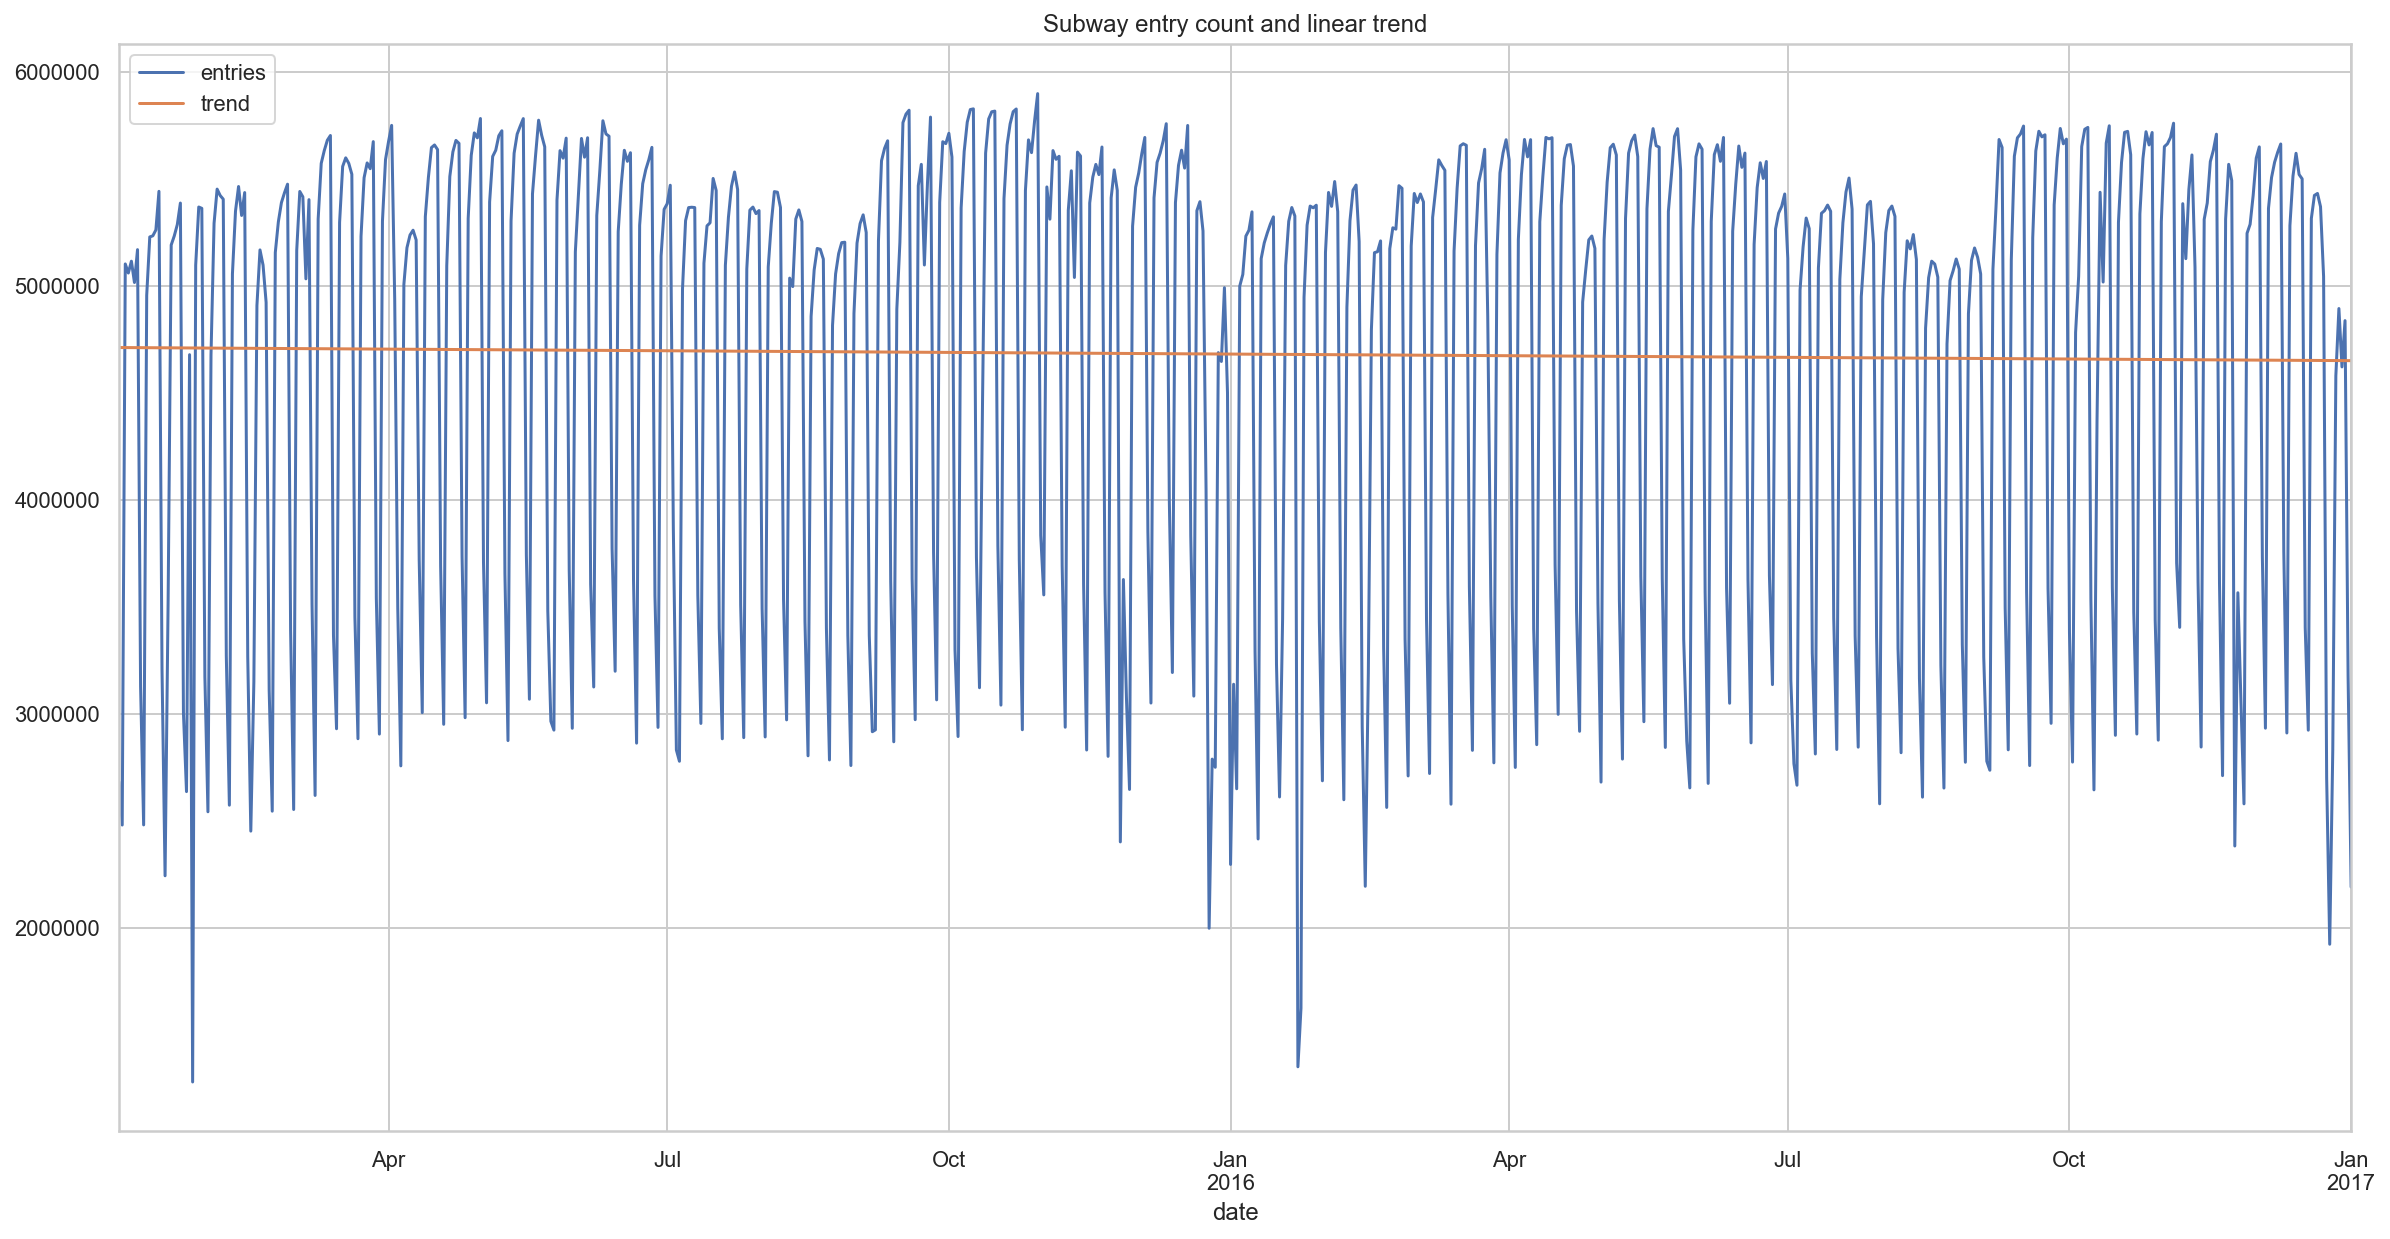

In [14]:
plt.figure(figsize=(20,10))
plt.title("Subway entry count and linear trend")
df_preCovid["entries"][:730].plot()
df_preCovid["trend"][:730].plot()

plt.legend(loc=2)
plt.show()

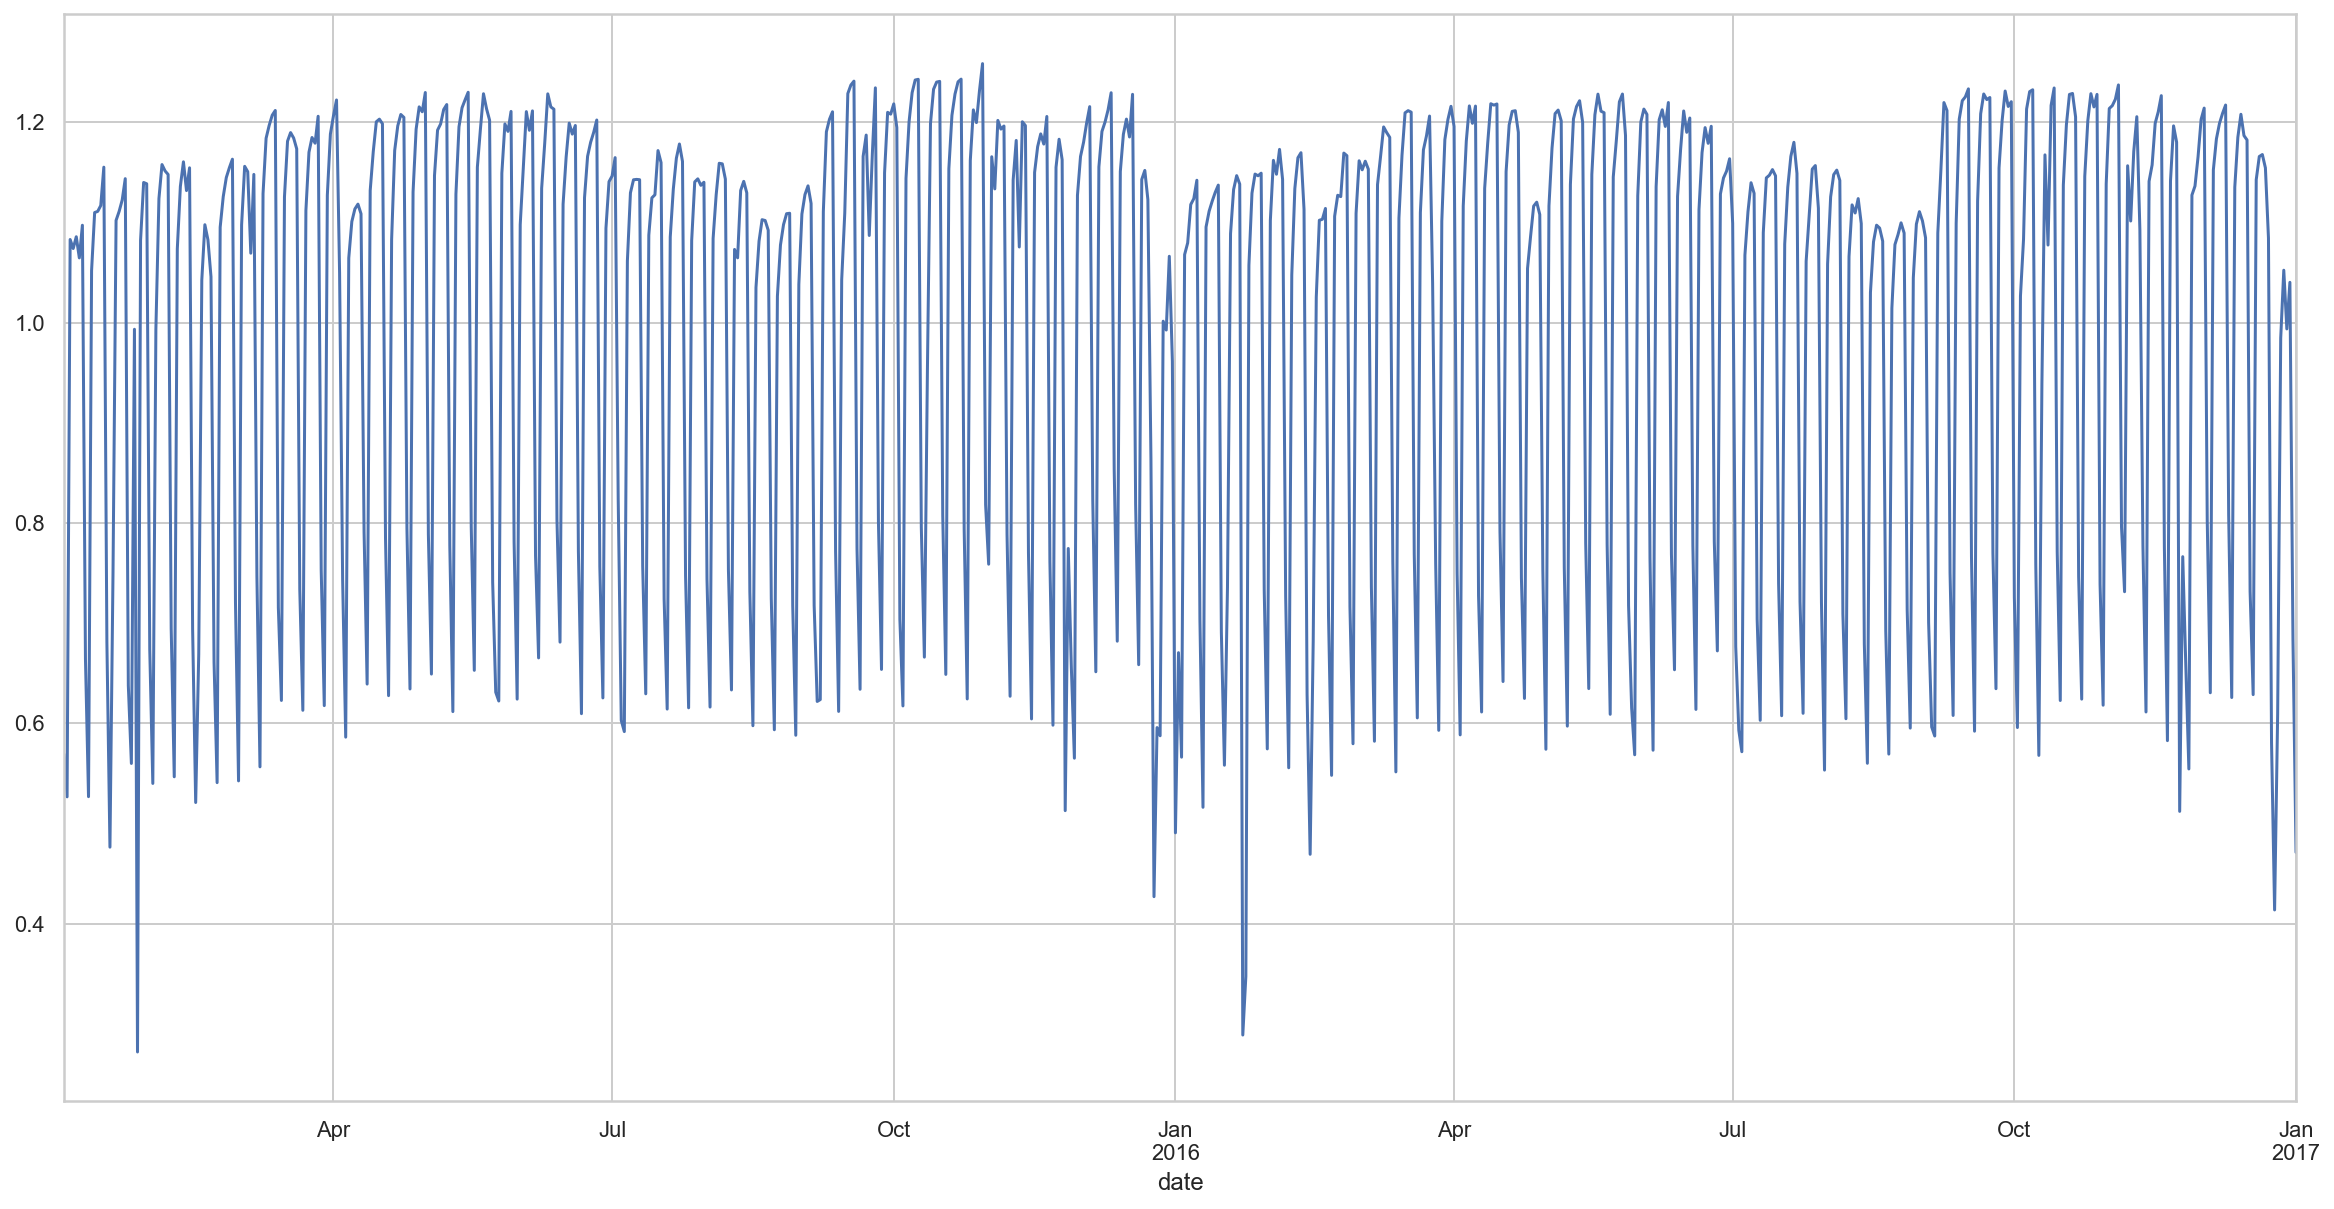

In [15]:
plt.figure(figsize=(20,10))
df_preCovid['entries_detrended'] = df_preCovid['entries'] / df_preCovid['trend']
df_preCovid['entries_detrended'][:730].plot()
plt.show()

### factor model

In [17]:
def remove_weekday_profile(row):
    return row['entries_detrended'] / weekday_factor[row['weekday']] 
def remove_month_profile(row):
    return row['entries_detrended_deweekdayed'] / month_factor[row['month']]

In [18]:
weekday_factor = df_preCovid.groupby('weekday')['entries_detrended'].mean().to_dict()
weekday_factor

{0: 1.0588606161352792,
 1: 1.1438514944420606,
 2: 1.1713828784114961,
 3: 1.1668333274657314,
 4: 1.162766715564485,
 5: 0.7225059094270215,
 6: 0.5840887317633129}

In [19]:
df_preCovid['entries_detrended_deweekdayed']  = df_preCovid.apply(remove_weekday_profile, axis=1)

In [20]:
month_factor = df_preCovid.groupby('month')['entries_detrended'].mean().to_dict()
month_factor

{1: 0.9291125378889891,
 2: 0.9680345557804182,
 3: 1.0176400996312998,
 4: 1.0315201276896933,
 5: 1.038388628751256,
 6: 1.0462923048271433,
 7: 0.9737059977107659,
 8: 0.9766733631167505,
 9: 1.0184195927744897,
 10: 1.0543622944661082,
 11: 1.0051709396273005,
 12: 0.9763741441348673}

In [21]:
df_preCovid['entries_detrended_deweekdayed_demonthed']  = df_preCovid.apply(remove_month_profile, axis=1)

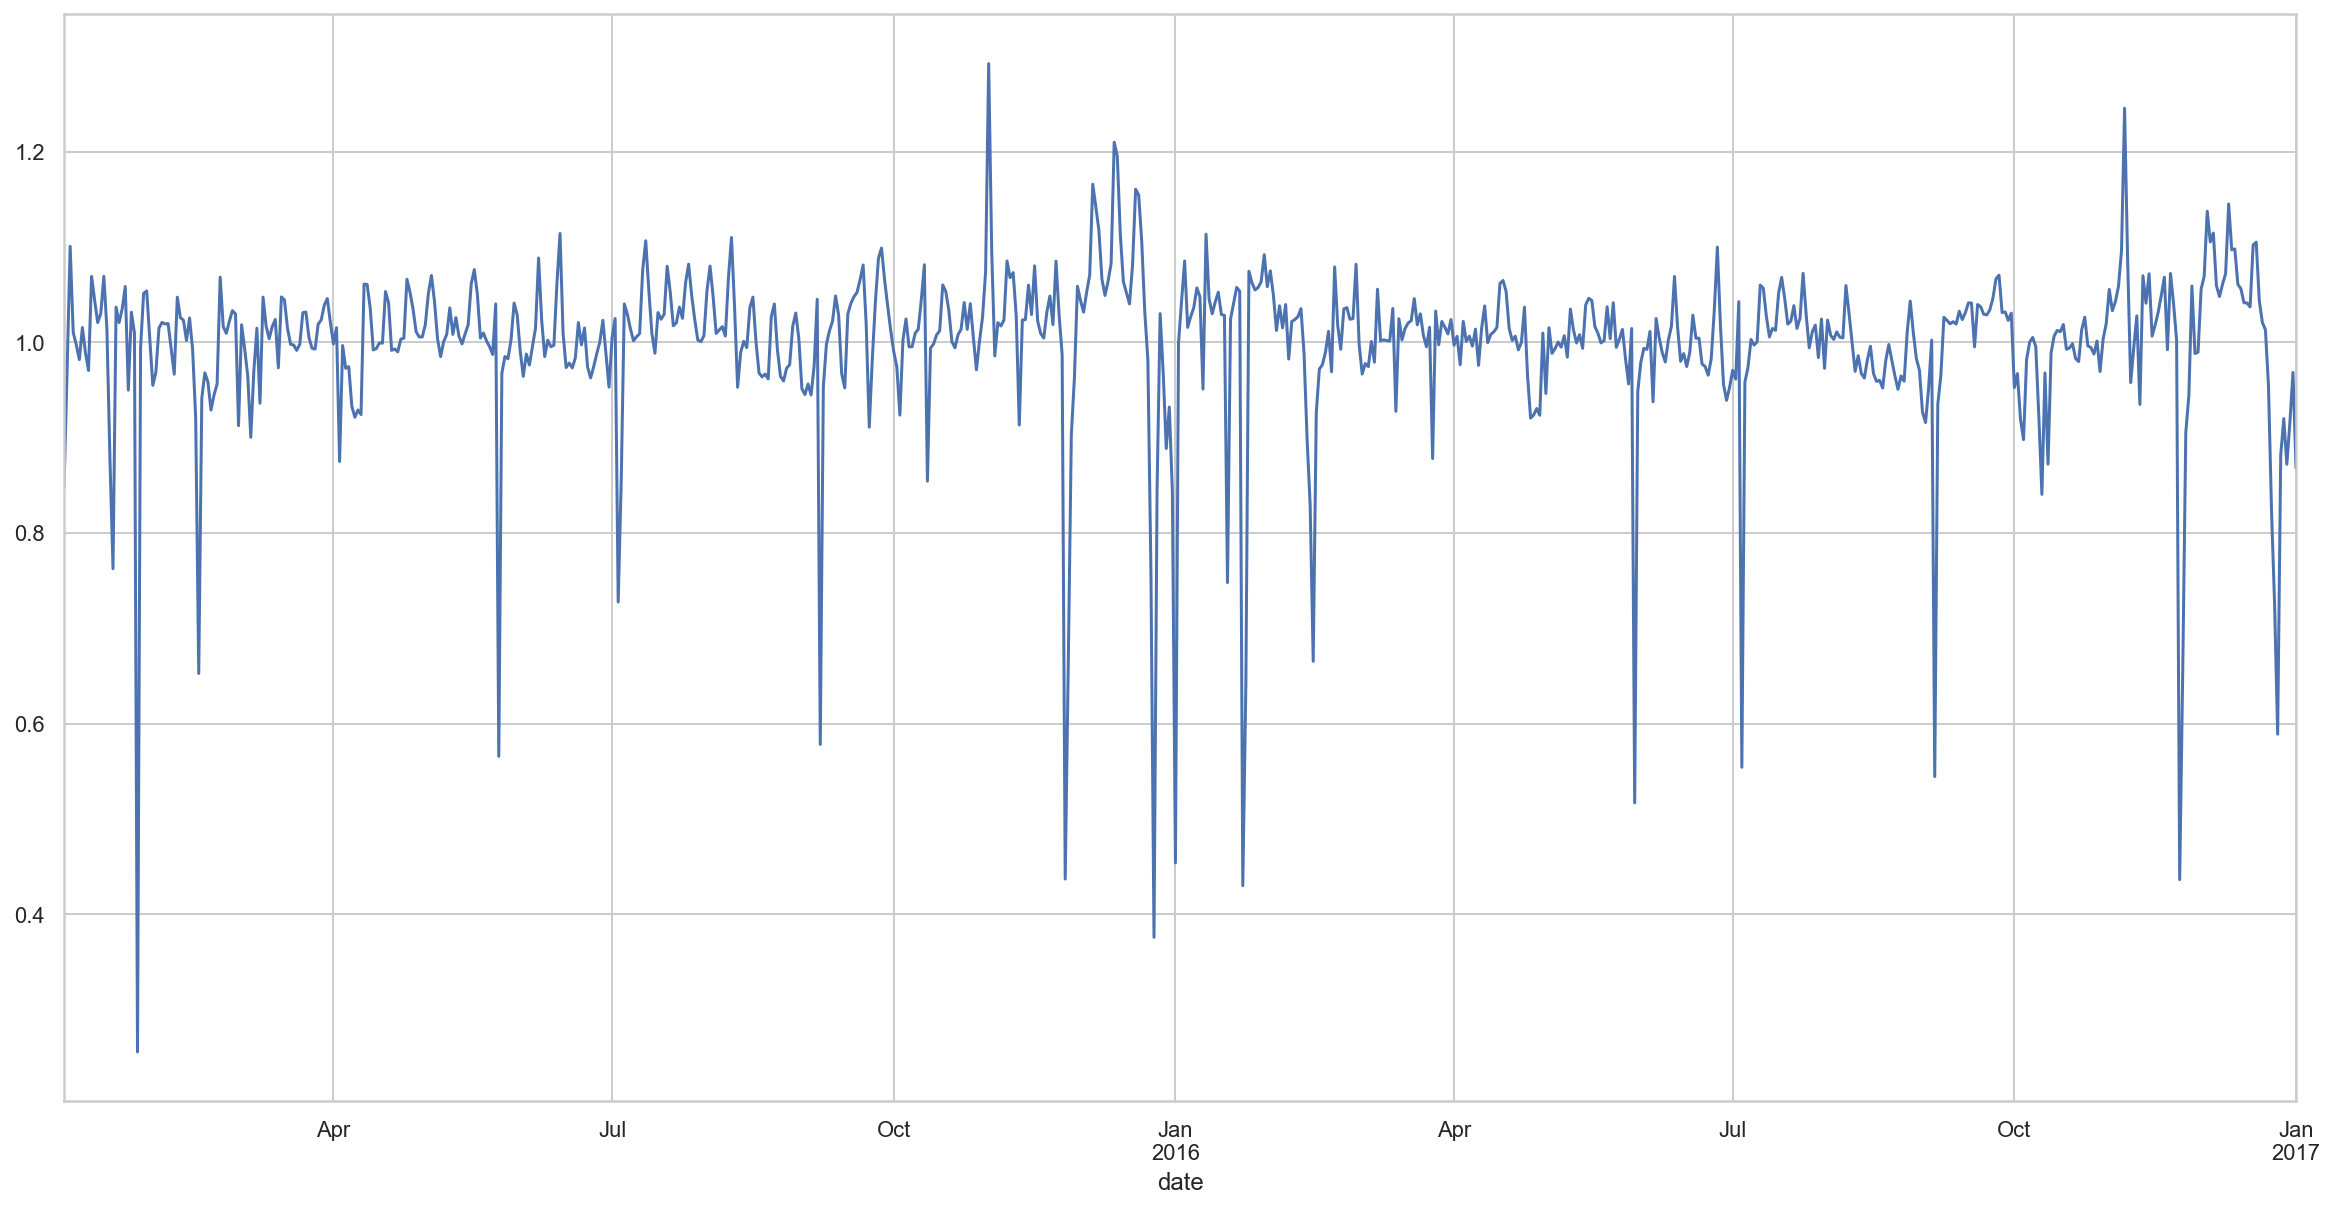

In [22]:
plt.figure(figsize=(20,10))
df_preCovid['entries_detrended_deweekdayed_demonthed'][:730].plot()
plt.show()

In [24]:
def factor_model(row):
    return row['trend'] * weekday_factor[row['weekday']] * month_factor[row['month']]

In [25]:
df_preCovid_train = df_preCovid[df_preCovid.index<'2019-01-01'] #(2015-01-03~2018-12-31)
df_preCovid_test = df_preCovid[~(df_preCovid.index<'2019-01-01')] #(2019-01-01~2020-02-29)

In [26]:
df_preCovid_train['factor_model'] = df_preCovid_train.apply(factor_model, axis=1)
df_preCovid_test['factor_model'] = df_preCovid_test.apply(factor_model, axis=1)

In [27]:
df_preCovid_train.head()

,entries,year,month,day,weekday,timeindex,trend,entries_detrended,entries_detrended_deweekdayed,entries_detrended_deweekdayed_demonthed,factor_model
date,,,,,,,,,,,
2015-01-03,2682846.0,2015,1,3,5,0.0,4.713360e+06,0.569200,0.787814,0.847921,3.164028e+06
2015-01-04,2481666.0,2015,1,4,6,1.0,4.713276e+06,0.526527,0.901450,0.970227,2.557820e+06
2015-01-05,5104111.0,2015,1,5,0,2.0,4.713192e+06,1.082941,1.022742,1.100773,4.636842e+06
2015-01-06,5061648.0,2015,1,6,1,3.0,4.713108e+06,1.073951,0.938890,1.010524,5.008935e+06
2015-01-07,5116883.0,2015,1,7,2,4.0,4.713024e+06,1.085690,0.926845,0.997559,5.129403e+06


In [28]:
df_preCovid_train.to_pickle('../Data/Subway_Data/preCovid_train.pkl')
df_preCovid_test.to_pickle('../Data/Subway_Data/preCovid_test.pkl')
df_preCovid.to_pickle('../Data/Subway_Data/preCovid.pkl')

<Figure size 432x288 with 0 Axes>

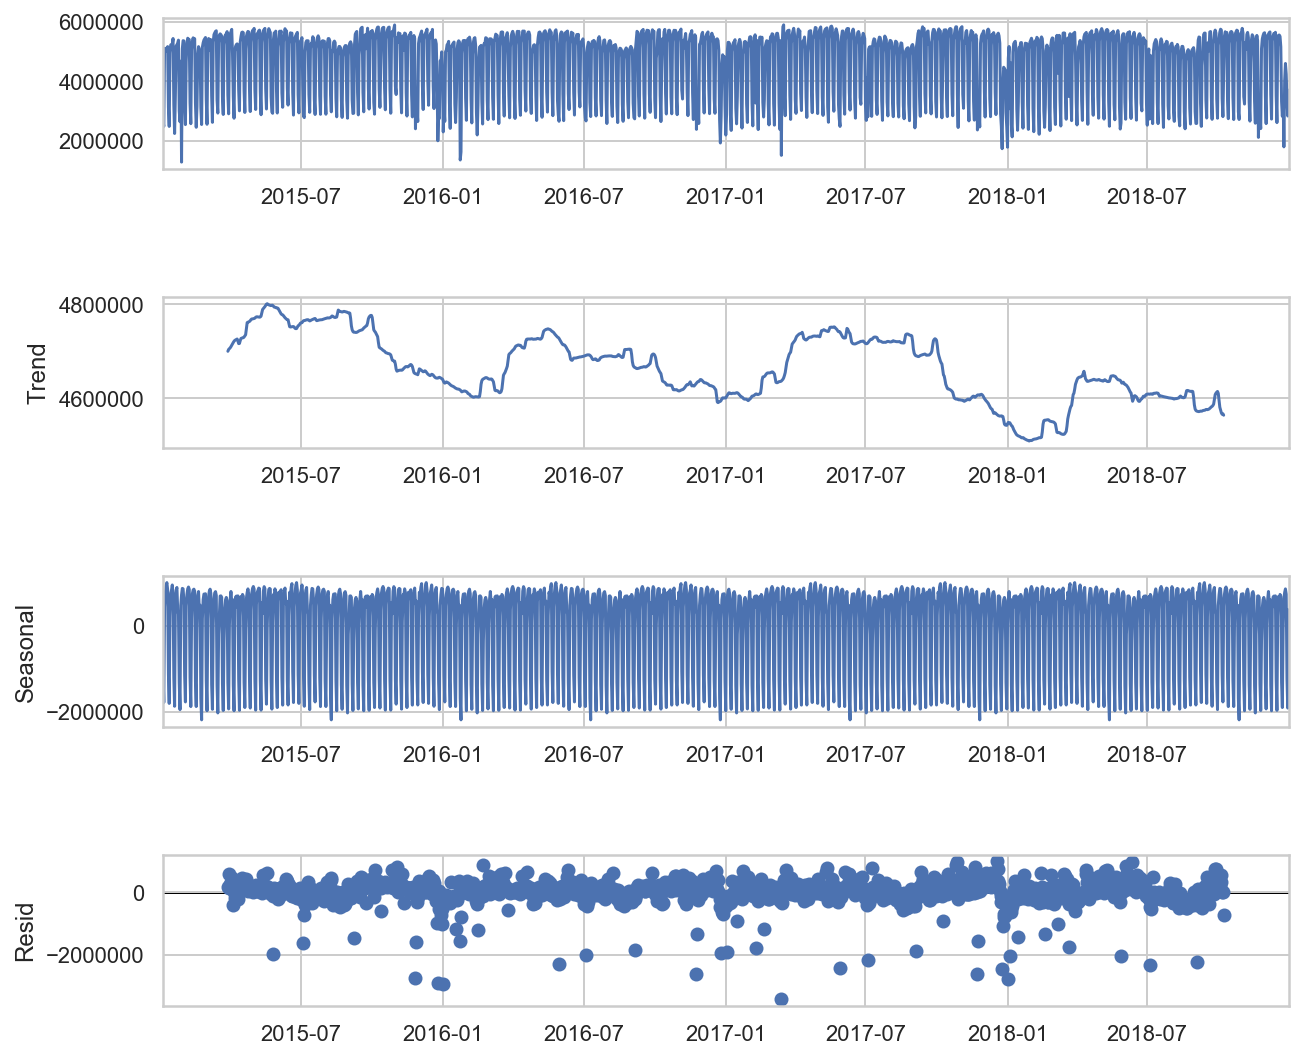

In [13]:
decomposition = seasonal_decompose(df_preCovid_train, freq=168) # freq:168(1 week)
fig = plt.figure()
fig = decomposition.plot()
fig.set_size_inches(10, 8)

### Modelling

In [47]:
def rmse(y_actual, y_predicted, print_val=True):
    """
    Args:
    -----
    y_actual - Array of actual target values
    y_predicted - Array of predicted target values
    print_val - If `True` (default), RMSE will be
                printed. Otherwise, it will be 
                returned.
    """
    err = sqrt(mean_squared_error(y_actual, y_predicted))
    if print_val:
        print('RMSE: {:,.2f}'.format(err))
    else:
        return err
    
    
def plot_forecast(actual, pred, title='Actual vs Forecast', 
                  xlabel='Date', ylabel='Subway Entry Counts', 
                  grid=True, figsize=(10, 5)):
    
    if len(actual) != len(pred):
        return_str = 'Unequal lengths error: '
        return_str += '({} actual, '.format(len(actual))
        return_str += '{} forecast)'.format(len(pred))
        return return_str
    
    plt.figure(figsize=figsize)
    plt.plot(actual, label='Actual')
    plt.plot(actual.index, pred, label='Predicted', c='r')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(actual.index.date, 
               actual.index.day)
    plt.xlim(min(actual.index.date), max(actual.index.date))
    plt.legend(loc=0)
    plt.grid(True)

In [96]:
# create SARIMAX model with previously determined lags
sar_m = sarimax.SARIMAX(df_preCovid_train['entries'],
                        trend='n', 
                        order=(1,1,0), 
                        seasonal_order=(1, 1, 0, 7), # weekly
                        simple_differencing=False).fit()

/Users/hyunjung/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/hyunjung/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


RMSE: 929,098.51


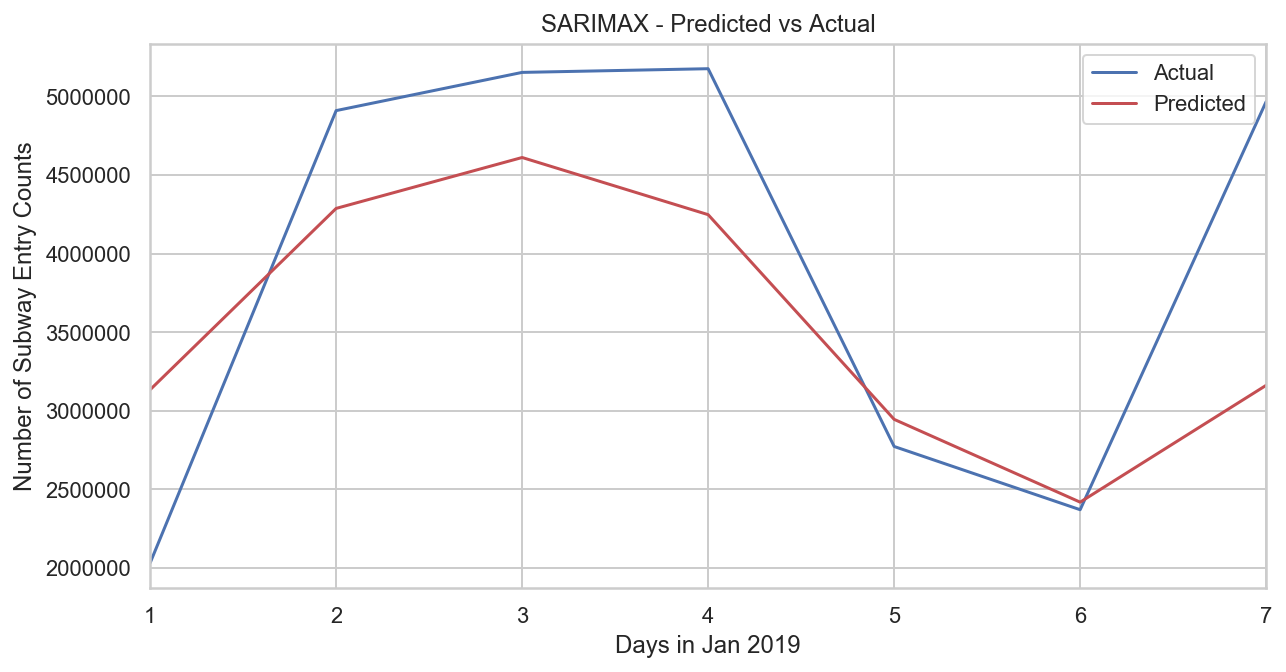

In [101]:
predict_steps = 7 #(predict one month)
forecast = sar_m.forecast(steps=predict_steps)

# plot against real data
plot_forecast(df_preCovid_test['entries'][:predict_steps], forecast, 
              title='SARIMAX - Predicted vs Actual', 
              xlabel='Days in Jan 2019', 
              ylabel='Number of Subway Entry Counts')

# calculate RMSE error
rmse(df_preCovid_test[:predict_steps].entries, forecast)

In [55]:
arima101 = sm.tsa.statespace.SARIMAX(df_preCovid_train, order=(1,0,0), seasonal_order= (1,0,0,7), simple_differencing=True)
model_results = arima101.fit()
model_results.summary()

/Users/hyunjung/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/hyunjung/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                           entries   No. Observations:                 1459
Model:             SARIMAX(1, 0, 0)x(1, 0, 0, 7)   Log Likelihood              -22009.591
Date:                           Mon, 30 Nov 2020   AIC                          44025.181
Time:                                   17:12:12   BIC                          44041.038
Sample:                               01-03-2015   HQIC                         44031.097
                                    - 12-31-2018                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3551      0.085      4.178      0.000       0.189       0.522
ar.S.L7        0.9723      0.019     52.176      0.000       0.936       1.009
sigma2      1.589e+12   6.56e-15   2.42e+26      0.000    1.59e+12    1.59e+12
===================================================================================
Ljung-Box (L1) (Q):                   2.72   Jarque-Bera (JB):             17483.89
Prob(Q):                              0.10   Prob(JB):                         0.00
Heteroskedasticity (H):               1.21   Skew:                            -0.20
Prob(H) (two-sided):                  0.04   Kurtosis:                        19.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.99e+41. Standard errors may be unstable.
"""